# **Deep Learning Project - Pothole detection** <br/>
# **HandCraft Model**
**Data Science and Advanced Analytics with a specialization in Data Science**<br/>
**NOVA IMS**<br/>
Authors of this notebook: 
*   Mafalda Paço - 20220619@novaims.unl.pt
*   Mª Margarida Graça - 20220602@novaims.unl.pt
*   Marta Dinis - 20220611@novaims.unl.pt
*   Nuno Dias - 20220603@novaims.unl.pt
*   Patrícia Morais - 20220638@novaims.unl.pt



## Ready to use Dataset
https://drive.google.com/file/d/1KE507iE7Hwb7TiJINnvMYCXNIGrEgPvt/view?usp=share_link

## **Summary**
In this notebook, to buid our handcraft model, we decided to use Keras functional API due to its flexibility. <br>
We started with a simple convolutional neural network and gradually adapted it to fit our needs in order to improve it. The main changes were made in order to reach better values of the overall accuracy of the model and, at the same time, minimize overfitting. We used a plot function to visualize the learning curves of the medtrics accuracy and AUROC throuhgout the epochs. 
All the choices made during the development of this model are detailed as we implemented them.


## **Data Import**

Necessary library imports.

In [ ]:
!pip install -q -U keras-tuner

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import time
import shutil
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, initializers, regularizers, optimizers, metrics 

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 1.9 MB/s eta 0:00:00


Connection to the Data Source. 

In [ ]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/DL/Project/"
main_folder, training_folder, testing_folder = "DATA/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'DATA.zip', 'DATA.zip')
    # Extract files
    zip_ = zipfile.ZipFile('DATA.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 2.551 seconds


Definition of a list of parameters for the  function `image_dataset_from_directory`. We defined the size to which all images will be resized as well as the the number of batches at a time that our model will be trained on. All of these parameters were adapted accordingly to our problem's complexity.

In [ ]:
image_size=(128, 128) # Experimetar
crop_to_aspect_ratio=True # Experimentar
color_mode='rgb'
batch_size=64
label_mode="binary"
validation_split=0.2
shuffle=True
seed=0

Loads the training data using the function `image_dataset_from_directory` and does an automatic split between training and validation data via validation_split, saving 20% for Validation.

In [ ]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)

Found 1436 files belonging to 2 classes.
Using 1149 files for training.
Using 287 files for validation.


Loads the testing data using the function `image_dataset_from_directory`.

In [ ]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 16 files belonging to 2 classes.


Defining the input shape of our data.

In [ ]:
input_shape = tuple(iter(ds_train).next()[0].shape)
input_shape

(64, 128, 128, 3)

## **Functions**

#### Plot function

This function that is used further on every models' analysis plots the accuracy, AUROC and loss curves for training and validation.

In [ ]:
def plot_result_curves(fit_history, model_name):
  '''
  This function takes as input the fitted history, with the accuracy, AUROC and Loss of our model and the model's name as the title of the plot
  Returns a plot with the accuracy, AUROC and loss curves
  '''
  df_hist = pd.DataFrame.from_dict(fit_history.history)
  df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

  secondary_y = ["accuracy", "val_accuracy", "AUROC", "val_AUROC"] 
  ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y, 
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Binary cross-entropy", 
                  xlabel="Epoch", title="Learning curves"+ " - " + model_name, 
                  style=[".--", ".-"]*3,
                  color=['darkred', 'indianred', "darkblue", "royalblue", "seagreen", "darkseagreen"], 
                         alpha=0.75, fontsize=10)
  ax.right_ax.set_ylabel("Accuracy")
  ax.right_ax.legend(loc=(1.15, 0.65), framealpha=1.0)
  ax.right_ax.set_ylim(0.45, 1.05)
  ax.legend(loc=(1.15, 0.40), framealpha=1.0)
  plt.show()

 ## **Baseline Model - Simple CNN**
We decided to start with a simple and lightweight CNN architecture as our baseline model given that we have a binary image classification problem. 
The model is composed by a single convolutional layer with 32 filters and a kernel size of 3x3, allowing it to capture simple image features like edges or textures. We chose to use the ReLU activation function and a global max pooling layer before the dense layer, which helps to reduce the spatial dimensionality of the feature maps. Finally, we used a dense layer with sigmoid activation to produce the output.

This model is relatively easy to train and has a small number of parameters, making it less prone to overfitting. Therefore, it can be a good starting point for further optimization and experimentation with more complex architectures.

In [ ]:
class SimpleCNN(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.gmp = layers.GlobalMaxPooling2D() 
        self.dense1 = layers.Dense(units=1, activation='sigmoid', 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn = SimpleCNN(seed=seed)
# Builds the DAG 
cnn.build(input_shape)
# Check the network
cnn.summary()
# Set control flag to True
train = True   

Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  896       
                                                                 
 global_max_pooling2d (Globa  multiple                 0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               multiple                  33        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if train:
    # Measure the start time
    start = time.time()
    
    learning_rate = 0.001
    cnn.compile(loss="binary_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
     
    epochs = 15
    history = cnn.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False


Epoch 1/15
18/18 [==============================] - 21s 337ms/step - loss: 29.7215 - accuracy: 0.5013 - AUROC: 0.5077 - val_loss: 3.3878 - val_accuracy: 0.4774 - val_AUROC: 0.5687
Epoch 2/15
18/18 [==============================] - 9s 333ms/step - loss: 1.5779 - accuracy: 0.5875 - AUROC: 0.6142 - val_loss: 0.6591 - val_accuracy: 0.6794 - val_AUROC: 0.7743
Epoch 3/15
18/18 [==============================] - 10s 268ms/step - loss: 0.9067 - accuracy: 0.6554 - AUROC: 0.7181 - val_loss: 0.5587 - val_accuracy: 0.7491 - val_AUROC: 0.8332
Epoch 4/15
18/18 [==============================] - 8s 339ms/step - loss: 0.7058 - accuracy: 0.7189 - AUROC: 0.7795 - val_loss: 0.5139 - val_accuracy: 0.7770 - val_AUROC: 0.8616
Epoch 5/15
18/18 [==============================] - 7s 265ms/step - loss: 0.6704 - accuracy: 0.7224 - AUROC: 0.7960 - val_loss: 0.5010 - val_accuracy: 0.7631 - val_AUROC: 0.8854
Epoch 6/15
18/18 [==============================] - 9s 261ms/step - loss: 0.6063 - accuracy: 0.7415 - AUROC

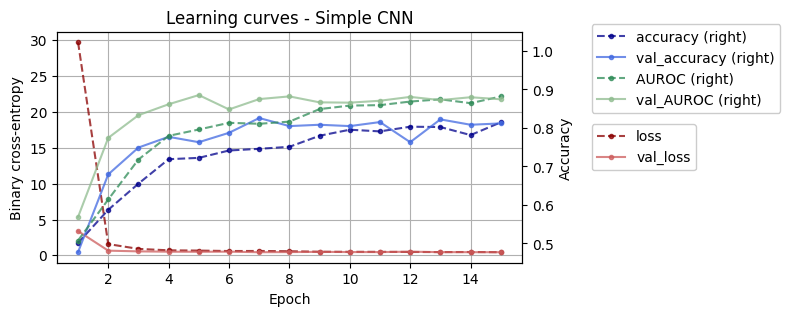

In [ ]:
# Plotting the results
plot_result_curves(history, "Simple CNN")

It seems that the model is learning given that the training and validation loss are decreasing over the epochs, and the accuracy and AUROC metrics are increasing. Nonetheless, the validation AUROC does not seem to improve much after the first few epochs, which may indicate that the model is starting to overfit to the training data.
In that sense the model's performance can still be improved. This can be addressed by introducing regularization techniques like dropout or L2 regularization.

By adding dropout to the model, we can increase its performance on both the training and test sets and improve its generalization, learning more robust features.

#### Adding dropout

In [ ]:
class SimpleCNN_DO(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dropout1 = layers.Dropout(0.2, seed=seed)  # Add dropout layer
        self.gmp = layers.GlobalMaxPooling2D() 
        self.dense1 = layers.Dense(units=1, activation='sigmoid', 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)  # Apply dropout to the output of conv1
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn_do = SimpleCNN_DO(seed=seed)
# Builds the DAG 
cnn_do.build(input_shape)
# Check the network
cnn_do.summary()
# Set control flag to True
train = True 

Model: "simple_cnn_do"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           multiple                  896       
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 global_max_pooling2d_1 (Glo  multiple                 0         
 balMaxPooling2D)                                                
                                                                 
 dense_1 (Dense)             multiple                  33        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if train:
    # Measure the start time
    start = time.time()
    
    learning_rate = 0.001
    cnn_do.compile(loss="binary_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
     
    epochs = 15
    history = cnn_do.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1)
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False

Epoch 1/15
18/18 [==============================] - 10s 368ms/step - loss: 31.7302 - accuracy: 0.5004 - AUROC: 0.5154 - val_loss: 1.6386 - val_accuracy: 0.4878 - val_AUROC: 0.6730
Epoch 2/15
18/18 [==============================] - 7s 275ms/step - loss: 1.2286 - accuracy: 0.6023 - AUROC: 0.6464 - val_loss: 0.5755 - val_accuracy: 0.7108 - val_AUROC: 0.8033
Epoch 3/15
18/18 [==============================] - 9s 321ms/step - loss: 0.7685 - accuracy: 0.6902 - AUROC: 0.7433 - val_loss: 0.5224 - val_accuracy: 0.7666 - val_AUROC: 0.8619
Epoch 4/15
18/18 [==============================] - 9s 345ms/step - loss: 0.6704 - accuracy: 0.7171 - AUROC: 0.7816 - val_loss: 0.4596 - val_accuracy: 0.7875 - val_AUROC: 0.8641
Epoch 5/15
18/18 [==============================] - 8s 326ms/step - loss: 0.6164 - accuracy: 0.7311 - AUROC: 0.7999 - val_loss: 0.4658 - val_accuracy: 0.7979 - val_AUROC: 0.8748
Epoch 6/15
18/18 [==============================] - 9s 288ms/step - loss: 0.5649 - accuracy: 0.7659 - AUROC:

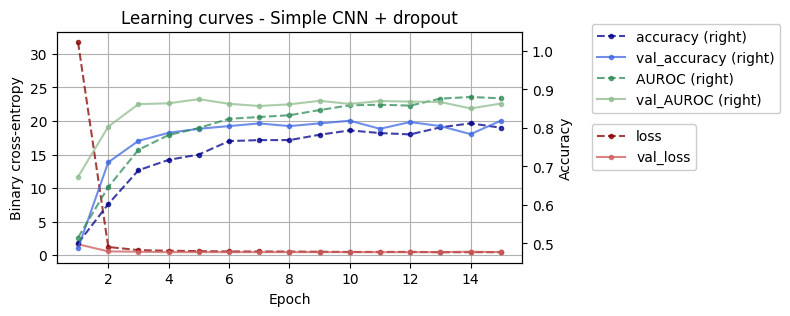

In [ ]:
# Plotting the results
plot_result_curves(history, "Simple CNN + dropout")

Comparing to the previous model, there does't seem be much of a difference in terms of accuracy or overfitting. However, this model's curves seem more smooth indicating that there was an improvement.

Regardless, it's important to note that the model still may be overfitting, as the validation accuracy is not improving much after the first few epochs. To solve such problem, we could try adding some other forms of regularization, such as L1 or L2 regularization, or early stopping.

#### Adding L2 and Early Stopping

We decided to add the L2 regularizer, also known as Ridge regularizer, as well as early stopping as they have complementary effects. L2 regularization prevents overfitting during the training process and is computationally more efficient. Early stopping prevents the training process from continuing when the set parameter, in our case 'validation loss', does not improve for a certain number of epochs (we defined it as 5 epochs). <br>
For this model only we also decreased the learning rate since our learning curve was very irregular, indicating that the model's weights may be oscillating around the optimal values.

In [ ]:
class SimpleCNN_DO_L2_ES(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dropout1 = layers.Dropout(0.2, seed=seed)  # Add dropout layer
        self.gmp = layers.GlobalMaxPooling2D() 
        self.dense1 = layers.Dense(units=1, activation='sigmoid', 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed),
                                   kernel_regularizer=regularizers.l2(0.01))  # Add L2 regularization
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)  # Apply dropout to the output of conv1
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn_do_L2_ES = SimpleCNN_DO_L2_ES(seed=seed)
# Builds the DAG 
cnn_do_L2_ES.build(input_shape)
# Check the network
cnn_do_L2_ES.summary()
# Set control flag to True
train = True 


Model: "simple_cnn_do_l2_es_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           multiple                  896       
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 global_max_pooling2d_3 (Glo  multiple                 0         
 balMaxPooling2D)                                                
                                                                 
 dense_3 (Dense)             multiple                  33        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
if train:
    # Measure the start time
    start = time.time()
    
    learning_rate = 0.0005
    cnn_do_L2_ES.compile(loss="binary_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    
    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    history = cnn_do_L2_ES.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1, callbacks=[early_stopping])
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False


Epoch 1/50
18/18 [==============================] - 8s 280ms/step - loss: 44.4046 - accuracy: 0.4830 - AUROC: 0.4830 - val_loss: 8.7385 - val_accuracy: 0.5261 - val_AUROC: 0.5150
Epoch 2/50
18/18 [==============================] - 9s 274ms/step - loss: 6.6589 - accuracy: 0.5205 - AUROC: 0.5207 - val_loss: 3.1895 - val_accuracy: 0.5610 - val_AUROC: 0.6327
Epoch 3/50
18/18 [==============================] - 9s 361ms/step - loss: 2.0179 - accuracy: 0.6153 - AUROC: 0.6518 - val_loss: 1.0604 - val_accuracy: 0.6899 - val_AUROC: 0.7507
Epoch 4/50
18/18 [==============================] - 7s 269ms/step - loss: 1.1810 - accuracy: 0.6614 - AUROC: 0.7263 - val_loss: 0.8635 - val_accuracy: 0.6516 - val_AUROC: 0.8163
Epoch 5/50
18/18 [==============================] - 9s 370ms/step - loss: 1.1206 - accuracy: 0.6789 - AUROC: 0.7432 - val_loss: 0.5652 - val_accuracy: 0.7526 - val_AUROC: 0.8324
Epoch 6/50
18/18 [==============================] - 7s 278ms/step - loss: 0.8294 - accuracy: 0.7250 - AUROC: 

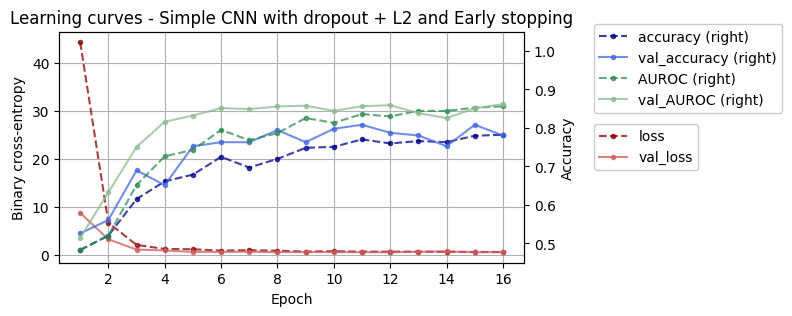

In [ ]:
# Plotting the results
plot_result_curves(history, "Simple CNN with dropout + L2 and Early stopping")

This model has a pretty good performance in terms of overfitting but we still want to improve the accuracy.
The next step would be to add more layers to the model's architecture.

#### Adding one more Convolutional Layer (2 CL)

To do so, we tried adding one more convolutional layer, which will hopefully give the model more capacity to learn complex patterns in the data.

In [ ]:
class SimpleCNN_DO_L2_ES_1(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.conv1 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.conv2 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dropout1 = layers.Dropout(0.2, seed=seed)  # Add dropout layer
        self.dense1 = layers.Dense(units=1, activation='sigmoid', 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed),
                                   kernel_regularizer=regularizers.l2(0.01))  # Add L2 regularization

       # Non-learnable layers (define only once)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D() 
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool2x2(x)
        x = self.dropout1(x)  # Apply dropout to the output of conv1
        x = self.conv2(x) # Add an additional convolutional layer
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn_do_L2_ES_1 = SimpleCNN_DO_L2_ES_1(seed=seed)
# Builds the DAG 
cnn_do_L2_ES_1.build(input_shape)
# Check the network
cnn_do_L2_ES_1.summary()
# Set control flag to True
train = True

Model: "simple_cnn_do_l2_es_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           multiple                  896       
                                                                 
 conv2d_5 (Conv2D)           multiple                  18496     
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_4 (Dense)             multiple                  65        
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 global_max_pooling2d_4 (Glo  multiple                 0         
 balMaxPooling2D)                            

In [ ]:
if train:
    # Measure the start time
    start = time.time()
    
    learning_rate = 0.001
    cnn_do_L2_ES_1.compile(loss="binary_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    
    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    history = cnn_do_L2_ES_1.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1, callbacks=[early_stopping])
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False

Epoch 1/50
18/18 [==============================] - 9s 291ms/step - loss: 19.0131 - accuracy: 0.5779 - AUROC: 0.5780 - val_loss: 0.9923 - val_accuracy: 0.6411 - val_AUROC: 0.6948
Epoch 2/50
18/18 [==============================] - 10s 309ms/step - loss: 0.8529 - accuracy: 0.6614 - AUROC: 0.7240 - val_loss: 0.7149 - val_accuracy: 0.7317 - val_AUROC: 0.7639
Epoch 3/50
18/18 [==============================] - 9s 353ms/step - loss: 0.7514 - accuracy: 0.6997 - AUROC: 0.7598 - val_loss: 0.7140 - val_accuracy: 0.6794 - val_AUROC: 0.7994
Epoch 4/50
18/18 [==============================] - 8s 280ms/step - loss: 0.7125 - accuracy: 0.7163 - AUROC: 0.7850 - val_loss: 0.6436 - val_accuracy: 0.7456 - val_AUROC: 0.7938
Epoch 5/50
18/18 [==============================] - 9s 349ms/step - loss: 0.6708 - accuracy: 0.7241 - AUROC: 0.7892 - val_loss: 0.6002 - val_accuracy: 0.7491 - val_AUROC: 0.8101
Epoch 6/50
18/18 [==============================] - 8s 333ms/step - loss: 0.6229 - accuracy: 0.7346 - AUROC:

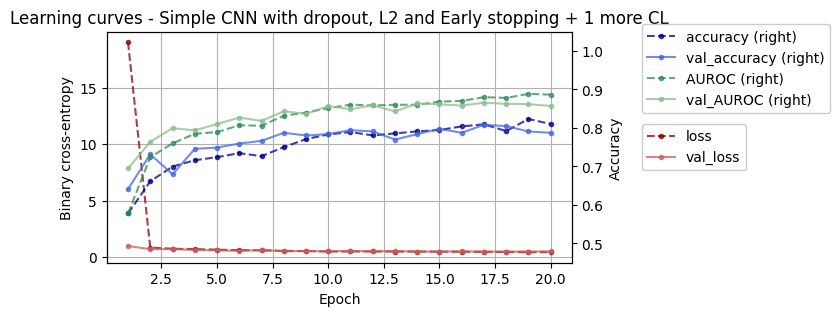

In [ ]:
# Plotting the results
plot_result_curves(history, "Simple CNN with dropout, L2 and Early stopping + 1 more CL")

The model seems to be working better but there is still room for improvement. Especially considering the accuracy and the overall learning of the model.

#### Adding Batch Normalization

Batch normalization is normally used to improve the performance of neural networks by improving the convergence speed as well as making the model more robust to changes in the input distribution. It can also act as a regularizer, which helps prevent overfitting. 

In [ ]:
class SimpleCNN_DO_L2_ES_1_BN(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.preprocess = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn2 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(0.2, seed=seed)  # Add dropout layer
        self.dense1 = layers.Dense(units=1, activation='sigmoid', 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed),
                                   kernel_regularizer=regularizers.l2(0.01))  # Add L2 regularization

       # Non-learnable layers (define only once)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D() 
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool2x2(x)
        x = self.dropout1(x)  # Apply dropout to the output of conv1

        x = self.conv2(x) # Add an additional convolutional layer
        x = self.bn2(x)
        x = self.gmp(x)
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn_do_L2_ES_1_BN = SimpleCNN_DO_L2_ES_1_BN(seed=seed)
# Builds the DAG 
cnn_do_L2_ES_1_BN.build(input_shape)
# Check the network
cnn_do_L2_ES_1_BN.summary()
# Set control flag to True
train = True

Model: "simple_cnn_do_l2_es_1_bn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  multiple                 12        
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           multiple                  896       
                                                                 
 batch_normalization_1 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           multiple                  18496     
                                                                 
 batch_normalization_2 (Batc  multiple                 256       
 hNormalization)                                                 
                                          

In [ ]:
if train:
    # Measure the start time
    start = time.time()
    
    learning_rate = 0.001
    cnn_do_L2_ES_1_BN.compile(loss="binary_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    
    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    history = cnn_do_L2_ES_1_BN.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1, callbacks=[early_stopping])
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False

Epoch 1/50
18/18 [==============================] - 11s 323ms/step - loss: 1.0494 - accuracy: 0.5466 - AUROC: 0.5558 - val_loss: 0.8297 - val_accuracy: 0.5261 - val_AUROC: 0.5180
Epoch 2/50
18/18 [==============================] - 9s 366ms/step - loss: 0.7710 - accuracy: 0.6144 - AUROC: 0.6598 - val_loss: 0.7295 - val_accuracy: 0.5296 - val_AUROC: 0.5749
Epoch 3/50
18/18 [==============================] - 8s 298ms/step - loss: 0.6399 - accuracy: 0.6797 - AUROC: 0.7513 - val_loss: 0.6985 - val_accuracy: 0.5436 - val_AUROC: 0.6478
Epoch 4/50
18/18 [==============================] - 9s 315ms/step - loss: 0.5909 - accuracy: 0.7189 - AUROC: 0.7942 - val_loss: 0.6793 - val_accuracy: 0.5889 - val_AUROC: 0.7067
Epoch 5/50
18/18 [==============================] - 9s 374ms/step - loss: 0.5844 - accuracy: 0.7180 - AUROC: 0.7926 - val_loss: 0.6622 - val_accuracy: 0.6237 - val_AUROC: 0.7528
Epoch 6/50
18/18 [==============================] - 8s 297ms/step - loss: 0.5854 - accuracy: 0.7293 - AUROC: 

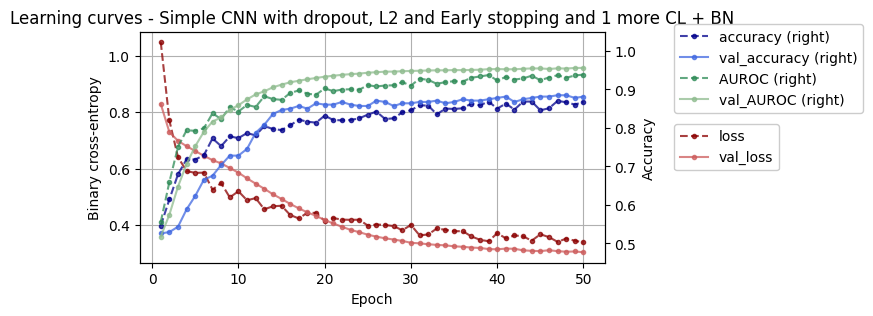

In [ ]:
# Plotting the results
plot_result_curves(history, "Simple CNN with dropout, L2 and Early stopping and 1 more CL + BN")

With this approach we were able to improve the model by increasing the accuracy values. We can also see that the loss curve is now decreasing in a more logarithmic shape in contrast with the previous model which had a big drop in the beggining and a very slow and slight decrease in the remaining epochs. <br>
Overall, the model appears to be performing better than the previous ones and has less overfitting.

#### Adding one more convolutional layer (3 CL) (BEST MODEL)

Now the main objective is to improve the accuracy so we tried to add one more convolutional layer. <br>
In this new model we only have one droupout, between the first two convolutional layers, given that, in the previous model, the val_accuracy is greater than the train_accuracy, which may indicate that we are using too few neurons in the training process, not allowing the train_accuracy to reach the val_accuracy values. However taking all dropout layers out of the model could cause overfitting. We also decreased the dropout rate of the remaning one, decreasing the percentage of neurons to not use in model's training process.<br>
We also implemented learning rate scheduling through ExponentialDecay which allows the learning rate to gradually decrease as the training progresses. This method could help the training process to reach a better solution faster.

In [ ]:
class SimpleCNN_DO_L2_ES_3CL_BN(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.preprocess = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn3 = layers.BatchNormalization()
        self.dense1 = layers.Dense(units=1, activation='sigmoid', 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed),
                                   kernel_regularizer=regularizers.l2(0.01))  # Add L2 regularization
        self.dropout1 = layers.Dropout(0.15, seed=seed)  # Add dropout layer
        
        
        # Non-learnable layers (define only once)
        self.gmp = layers.GlobalMaxPooling2D() 
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool2x2(x)
        x = self.dropout1(x)  # Apply dropout to the output of conv1
  
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.maxpool2x2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.gmp(x)
        x = self.dense1(x)
        return x


# Create an instance of CustomCNN
cnn_do_L2_ES_3CL_BN = SimpleCNN_DO_L2_ES_3CL_BN(seed=seed)
# Builds the DAG 
cnn_do_L2_ES_3CL_BN.build(input_shape)
# Check the network
cnn_do_L2_ES_3CL_BN.summary()
# Set control flag to True
train = True 

Model: "simple_cnn_do_l2_es_3cl_bn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_3 (Batc  multiple                 12        
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           multiple                  896       
                                                                 
 batch_normalization_4 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           multiple                  18496     
                                                                 
 batch_normalization_5 (Batc  multiple                 256       
 hNormalization)                                                 
                                        

In [ ]:
if train:
    # Measure the start time
    start = time.time()
    
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)
    cnn_do_L2_ES_3CL_BN.compile(loss="binary_crossentropy",              #novo
                     optimizer=optimizers.SGD(learning_rate=lr_schedule),
                     metrics=[metrics.BinaryAccuracy(name='accuracy'),
                              metrics.AUC(name='AUROC')])
    
    epochs = 70
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    history = cnn_do_L2_ES_3CL_BN.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1, callbacks=[early_stopping])
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False


Epoch 1/70
18/18 [==============================] - 11s 377ms/step - loss: 0.9071 - accuracy: 0.5570 - AUROC: 0.5781 - val_loss: 0.9844 - val_accuracy: 0.4774 - val_AUROC: 0.5995
Epoch 2/70
18/18 [==============================] - 8s 298ms/step - loss: 0.6789 - accuracy: 0.6510 - AUROC: 0.7162 - val_loss: 0.8265 - val_accuracy: 0.4774 - val_AUROC: 0.6395
Epoch 3/70
18/18 [==============================] - 9s 374ms/step - loss: 0.5849 - accuracy: 0.7163 - AUROC: 0.7922 - val_loss: 0.7621 - val_accuracy: 0.4774 - val_AUROC: 0.6745
Epoch 4/70
18/18 [==============================] - 8s 334ms/step - loss: 0.5287 - accuracy: 0.7598 - AUROC: 0.8349 - val_loss: 0.7382 - val_accuracy: 0.4808 - val_AUROC: 0.7062
Epoch 5/70
18/18 [==============================] - 9s 294ms/step - loss: 0.4996 - accuracy: 0.7702 - AUROC: 0.8507 - val_loss: 0.7228 - val_accuracy: 0.4878 - val_AUROC: 0.7381
Epoch 6/70
18/18 [==============================] - 9s 369ms/step - loss: 0.4594 - accuracy: 0.8042 - AUROC: 

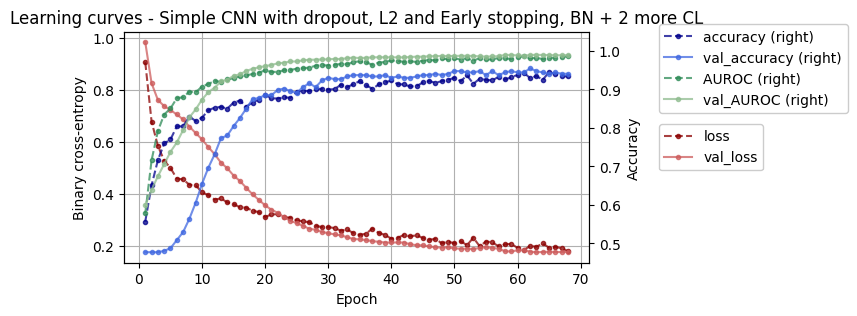

In [ ]:
# Plotting the results
plot_result_curves(history, "Simple CNN with dropout, L2 and Early stopping, BN + 2 more CL")

With this model we got even smoother learning curves and better accuracy in both train and validation as well as pratically no 
overfitting.

#### Adding one hidden dense layer

Now we tried adding one dense_hidden layer to the model after the global max pooling operation. Its purpose was to help extract features from the convolutional layers to the final output layer, allowing the model to learn more complex patterns. This addition may improve the model's accuracy.

In [ ]:
class SimpleCNN_DO_L2_ES_BN_HD(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.preprocess = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn3 = layers.BatchNormalization()
        self.dense_hidden = layers.Dense(units=64, activation='relu',
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense1 = layers.Dense(units=1, activation='sigmoid',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed),
                                   kernel_regularizer=regularizers.l2(0.01))  # Add L2 regularization
        self.dropout1 = layers.Dropout(0.15, seed=seed)  # Add dropout layer
        self.dropout2 = layers.Dropout(0.15, seed=seed)  # Add dropout layer

        # Non-learnable layers (define only once)
        self.gmp = layers.GlobalMaxPooling2D()
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)

    def call(self, inputs):
        x = self.preprocess(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool2x2(x)
        x = self.dropout1(x)  # Apply dropout to the output of conv1

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.maxpool2x2(x)
        #x = self.dropout2(x)  # Apply dropout to the output of conv1

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.gmp(x)
        x = self.dense_hidden(x)  # Add the additional Dense layer
        x = self.dense1(x)
        return x

# Create an instance of CustomCNN
cnn_do_L2_ES_BN_HD = SimpleCNN_DO_L2_ES_BN_HD(seed=seed)
# Builds the DAG
cnn_do_L2_ES_BN_HD.build(input_shape)
# Check the network
cnn_do_L2_ES_BN_HD.summary()
# Set control flag to True
train = True

Model: "simple_cnn_do_l2_es_bn_hd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Batc  multiple                 12        
 hNormalization)                                                 
                                                                 
 conv2d_11 (Conv2D)          multiple                  896       
                                                                 
 batch_normalization_8 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 conv2d_12 (Conv2D)          multiple                  18496     
                                                                 
 batch_normalization_9 (Batc  multiple                 256       
 hNormalization)                                                 
                                         

In [ ]:
if train:
    # Measure the start time
    start = time.time()
    
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.96,
        staircase=True)
    cnn_do_L2_ES_BN_HD.compile(loss="binary_crossentropy",
                            optimizer=optimizers.SGD(learning_rate=lr_schedule),
                            metrics=[metrics.BinaryAccuracy(name='accuracy'),
                                     metrics.AUC(name='AUROC')])
    
    epochs = 70
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    history = cnn_do_L2_ES_BN_HD.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1, callbacks=[early_stopping])
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed
    train = False


Epoch 1/70
18/18 [==============================] - 11s 349ms/step - loss: 0.8481 - accuracy: 0.5300 - AUROC: 0.5442 - val_loss: 0.7381 - val_accuracy: 0.4913 - val_AUROC: 0.5054
Epoch 2/70
18/18 [==============================] - 9s 370ms/step - loss: 0.6795 - accuracy: 0.6510 - AUROC: 0.6941 - val_loss: 0.7263 - val_accuracy: 0.5017 - val_AUROC: 0.5432
Epoch 3/70
18/18 [==============================] - 8s 300ms/step - loss: 0.6131 - accuracy: 0.6867 - AUROC: 0.7539 - val_loss: 0.7224 - val_accuracy: 0.5192 - val_AUROC: 0.5844
Epoch 4/70
18/18 [==============================] - 10s 398ms/step - loss: 0.5530 - accuracy: 0.7224 - AUROC: 0.8083 - val_loss: 0.7147 - val_accuracy: 0.5192 - val_AUROC: 0.6179
Epoch 5/70
18/18 [==============================] - 9s 370ms/step - loss: 0.5022 - accuracy: 0.7746 - AUROC: 0.8537 - val_loss: 0.7064 - val_accuracy: 0.5470 - val_AUROC: 0.6620
Epoch 6/70
18/18 [==============================] - 8s 294ms/step - loss: 0.5020 - accuracy: 0.7668 - AUROC:

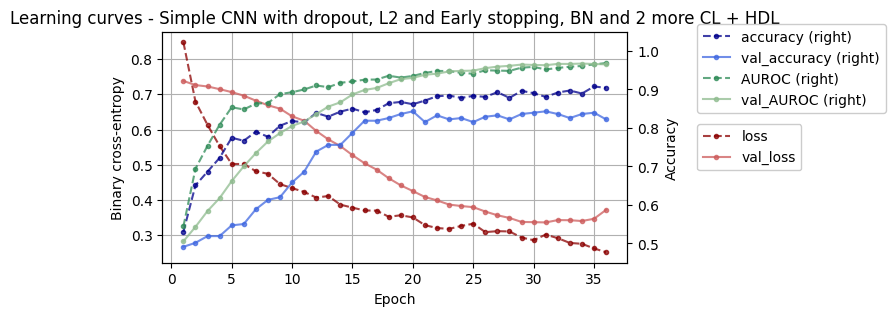

In [ ]:
# Plotting the results
plot_result_curves(history, "Simple CNN with dropout, L2 and Early stopping, BN and 2 more CL + HDL")

Adding the hidden dense layer didn't improve our results, acctualy decreased the accuracy and increased overfitting. Therefore we won't keep this model.

#### Adding one more convolutional layer (4 CL)

As previuosly done, we added one more convolutional layer to see if our model would perform better.

In [ ]:
class SimpleCNN_DO_L2_ES_4CL_BN(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        self.preprocess = layers.BatchNormalization()
        self.conv1 = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn3 = layers.BatchNormalization()
        self.conv4 = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.bn4 = layers.BatchNormalization()
        self.dense1 = layers.Dense(units=1, activation='sigmoid', 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed),
                                   kernel_regularizer=regularizers.l2(0.01))  # Add L2 regularization
        self.dropout1 = layers.Dropout(0.2, seed=seed)  # Add dropout layer
        self.dropout2 = layers.Dropout(0.2, seed=seed)  # Add dropout layer
        self.dropout3 = layers.Dropout(0.2, seed=seed)  # Add dropout layer
        
        # Non-learnable layers (define only once)
        self.gmp = layers.GlobalMaxPooling2D() 
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        
    def call(self, inputs):
        x = self.preprocess(inputs)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.maxpool2x2(x)
        x = self.dropout1(x)  # Apply dropout to the output of conv1
  
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.maxpool2x2(x)
        x = self.dropout2(x)  # Apply dropout to the output of conv1

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.maxpool2x2(x)
        x = self.dropout3(x)  # Apply dropout to the output of conv1

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.gmp(x)
        x = self.dense1(x)
        return x


# Create an instance of CustomCNN
cnn_do_L2_ES_4CL_BN = SimpleCNN_DO_L2_ES_4CL_BN(seed=seed)
# Builds the DAG 
cnn_do_L2_ES_4CL_BN.build(input_shape)
# Check the network
cnn_do_L2_ES_4CL_BN.summary()
# Set control flag to True
train = True 

Model: "simple_cnn_do_l2_es_4cl_bn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_11 (Bat  multiple                 12        
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          multiple                  896       
                                                                 
 batch_normalization_12 (Bat  multiple                 128       
 chNormalization)                                                
                                                                 
 conv2d_15 (Conv2D)          multiple                  18496     
                                                                 
 batch_normalization_13 (Bat  multiple                 256       
 chNormalization)                                                
                                        

In [ ]:
if train:
    # Measure the start time
    start = time.time()
    
    learning_rate = 0.001
    cnn_do_L2_ES_4CL_BN.compile(loss="binary_crossentropy",
                 optimizer=optimizers.SGD(learning_rate=learning_rate),  
                 metrics=[metrics.BinaryAccuracy(name='accuracy'),
                          metrics.AUC(name='AUROC')])
    
    epochs = 70
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
    history = cnn_do_L2_ES_4CL_BN.fit(ds_train, validation_data=ds_val, epochs=epochs, verbose=1, callbacks=[early_stopping])
    # Measure the end time
    print("Training time: {:.4f}s".format(time.time() - start))
    # Do not train once this cell was executed 
    train = False

Epoch 1/70
18/18 [==============================] - 11s 380ms/step - loss: 0.8562 - accuracy: 0.5918 - AUROC: 0.6102 - val_loss: 0.7120 - val_accuracy: 0.5366 - val_AUROC: 0.5120
Epoch 2/70
18/18 [==============================] - 8s 299ms/step - loss: 0.6648 - accuracy: 0.6675 - AUROC: 0.7236 - val_loss: 0.7040 - val_accuracy: 0.5575 - val_AUROC: 0.5723
Epoch 3/70
18/18 [==============================] - 9s 301ms/step - loss: 0.5696 - accuracy: 0.7171 - AUROC: 0.7951 - val_loss: 0.7056 - val_accuracy: 0.5122 - val_AUROC: 0.5986
Epoch 4/70
18/18 [==============================] - 9s 377ms/step - loss: 0.5319 - accuracy: 0.7389 - AUROC: 0.8291 - val_loss: 0.7031 - val_accuracy: 0.5122 - val_AUROC: 0.6353
Epoch 5/70
18/18 [==============================] - 8s 297ms/step - loss: 0.5034 - accuracy: 0.7598 - AUROC: 0.8458 - val_loss: 0.6989 - val_accuracy: 0.5261 - val_AUROC: 0.6789
Epoch 6/70
18/18 [==============================] - 9s 364ms/step - loss: 0.4645 - accuracy: 0.7946 - AUROC: 

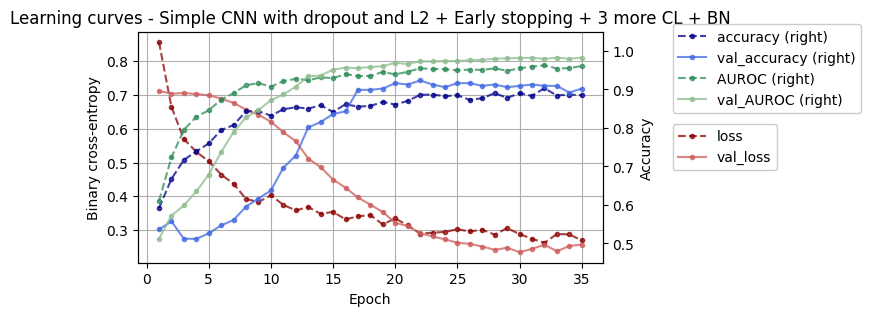

In [ ]:
# Plotting the results
plot_result_curves(history, "Simple CNN with dropout and L2 + Early stopping + 3 more CL + BN")

Given that adding another convolutional layer didn't seem to improve the model's accuracy and our problem is image binary classification, thus not very complex, we don't think we should add more convolution layers.

Now we used the best model we created to predict the test images and printed each one with the respective class (since our test data is very small we printed every image). 

1/1 [==============================] - 0s 52ms/step


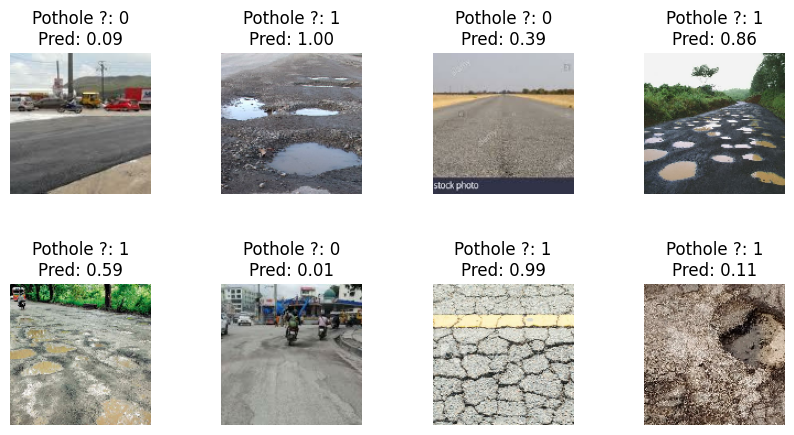

In [ ]:
# Use the trained model to predict on the test data
test_predictions = cnn_do_L2_ES_3CL_BN.predict(ds_test)

# Print some test images with their respective predictions
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(10, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, (image, label) in enumerate(ds_test.unbatch().take(8)):
    row, col = divmod(i, 4)
    axs[row][col].imshow(image.numpy().astype("uint8"))
    axs[row][col].set_title("Pothole ?: {}\nPred: {:.2f}".format(int(label.numpy()), test_predictions[i][0]))
    axs[row][col].axis("off")

plt.show()

We can see that the predictions of our model are pretty accurate.